In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RepeatedKFold
from sklearn.svm import SVR
import xgboost
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
plt.style.use('seaborn-white')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)

In [2]:
def remove_outliers(df,cols):
    for col in cols:
        q1,q3,IQR = df[col].quantile(q=0.25),df[col].quantile(q=0.75), df[col].quantile(q=0.75) - df[col].quantile(q=0.25)
        df = df.loc[df[col][(df[col] <= q3 + 1.5 * IQR) & (df[col] >= q1 - 1.5 * IQR)].index]
    return df


In [3]:
FILE="Philly_Kaggle.CSV"
data = pd.read_csv(FILE)
data.head(10)

,Address,Zillow Address,Sale Date,Opening Bid,Sale Price/bid price,Book/Writ,OPA,Postal Code,Attorney,Ward,...,School Score,Zillow Estimate,Rent Estimate,taxAssessment,yearBuilt,finished \n(SqFt),bathrooms,bedrooms,PropType,Average comps
0,2327 E SERGEANT ST,"2327 E SERGEANT ST , Philadelphia, PA 19125",September 13 2016,11400.0,"$11,400",1609-412,314095100.0,19125.0,PHELAN HALLINAN LLP,31.0,...,15.87,"228,663.00","1,500.00","174,000.00",1921.0,898.0,1,2,SingleFamily,"240,254.55"
1,4466 TOLBUT ST,"4466 TOLBUT ST , Philadelphia, PA 19136",August 2 2016,8500.0,"$8,500",1606-339,652092800.0,19136.0,PARKER MCCAY,65.0,...,32.53,"141,579.00","1,200.00","119,700.00",1959.0,1120.0,1.5,3,Townhouse,"150,937.50"
2,134 E WALNUT LN,"134 E WALNUT LN , Philadelphia, PA 19144",August 2 2016,12600.0,"$12,600",1605-426,592058735.0,19144.0,PHELAN HALLINAN LLP,59.0,...,7.89,"186,172.00","1,500.00","190,300.00",2006.0,1882.0,3,3,SingleFamily,"225,483.33"
3,111 W ABBOTTSFORD AVE,"111 W ABBOTTSFORD AVE , Philadelphia, PA 19144",August 2 2016,9200.0,"$9,200",1607-317,123016300.0,19144.0,KML LAW GROUP,12.0,...,7.89,"168,557.00","1,400.00","118,300.00",1900.0,1792.0,1,4,SingleFamily,"135,755.56"
4,146 E DUVAL ST,"146 E DUVAL ST , Philadelphia, PA 19144",August 2 2016,8900.0,"$8,900",1605-510,592159100.0,19144.0,PHELAN HALLINAN LLP,59.0,...,7.89,"135,045.00","1,350.00","113,700.00",1925.0,1419.0,2,3,SingleFamily,"144,120.00"
5,1131 HELLERMAN ST,"1131 HELLERMAN ST , Philadelphia, PA 19111",September 13 2016,8800.0,"$8,800",1602-643,531129700.0,19111.0,PHELAN HALLINAN LLP,53.0,...,23.84,"133,871.00","1,200.00","120,100.00",1947.0,1260.0,1.5,3,Townhouse,"126,000.00"
6,313 SALAIGNAC ST,"313 SALAIGNAC ST , Philadelphia, PA 19128",September 13 2016,10900.0,"$10,900",1609-568,212002100.0,19128.0,KML LAW GROUP,21.0,...,38.33,"192,442.00","1,350.00","55,500.00",1955.0,896.0,1,2,Townhouse,"215,612.50"
7,4408 SHERWOOD RD,"4408 SHERWOOD RD , Philadelphia, PA 19131",October 4 2016,10000.0,"$10,000",1610-357,521194100.0,19131.0,PHELAN HALLINAN LLP,52.0,...,8.34,"155,873.00","1,500.00","114,800.00",1925.0,1354.0,1,3,SingleFamily,"145,408.13"
8,3545 TUDOR ST,"3545 TUDOR ST , Philadelphia, PA 19136",September 13 2016,10800.0,"$10,800",1609-627,642138100.0,19136.0,DUANE MORRIS LLP,64.0,...,32.53,"142,309.00","1,150.00","136,200.00",1963.0,1616.0,1,4,Townhouse,"127,921.43"
9,7034 WHEELER ST,"7034 WHEELER ST , Philadelphia, PA 19142",October 4 2016,7100.0,"$7,100",1610-520,406204700.0,19142.0,MILSTEAD & ASSOCIATES LLC,40.0,...,7.28,"96,713.00","1,050.00","70,500.00",1925.0,992.0,1,3,Condominium,"95,016.13"


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805 entries, 0 to 804
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Address                    615 non-null    object 
 1   Zillow Address             615 non-null    object 
 2   Sale Date                  615 non-null    object 
 3   Opening Bid                610 non-null    float64
 4   Sale Price/bid price       615 non-null    object 
 5   Book/Writ                  615 non-null    object 
 6   OPA                        615 non-null    float64
 7   Postal Code                615 non-null    float64
 8   Attorney                   615 non-null    object 
 9   Ward                       615 non-null    float64
 10  Seller                     615 non-null    object 
 11  Buyer                      615 non-null    object 
 12  Sheriff Cost               615 non-null    float64
 13  Advertising                615 non-null    float64

In [5]:
data=data.replace(',','',regex=True)
data['Sale Price/bid price']=data['Sale Price/bid price'].str.replace('$','',regex=True)
data=data.replace(' -   ',np.nan)

In [6]:
data.isnull().sum()

Address                      190
Zillow Address               190
Sale Date                    190
Opening Bid                  195
Sale Price/bid price         190
Book/Writ                    190
OPA                          190
Postal Code                  190
Attorney                     190
Ward                         190
Seller                       190
Buyer                        190
Sheriff Cost                 190
Advertising                  190
Other                        190
Record Deed                  190
Water                        190
PGW                          190
 Avg Walk&Transit score      190
 Violent Crime Rate          190
 School Score                190
Zillow Estimate              190
Rent Estimate                190
taxAssessment                190
yearBuilt                    190
finished \n(SqFt)            190
 bathrooms                   225
 bedrooms                    220
PropType                     190
Average comps                190
dtype: int

In [7]:
data.dropna(axis=0,inplace=True)


In [8]:
data.isnull().sum()

Address                      0
Zillow Address               0
Sale Date                    0
Opening Bid                  0
Sale Price/bid price         0
Book/Writ                    0
OPA                          0
Postal Code                  0
Attorney                     0
Ward                         0
Seller                       0
Buyer                        0
Sheriff Cost                 0
Advertising                  0
Other                        0
Record Deed                  0
Water                        0
PGW                          0
 Avg Walk&Transit score      0
 Violent Crime Rate          0
 School Score                0
Zillow Estimate              0
Rent Estimate                0
taxAssessment                0
yearBuilt                    0
finished \n(SqFt)            0
 bathrooms                   0
 bedrooms                    0
PropType                     0
Average comps                0
dtype: int64

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 575 entries, 0 to 804
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Address                    575 non-null    object 
 1   Zillow Address             575 non-null    object 
 2   Sale Date                  575 non-null    object 
 3   Opening Bid                575 non-null    float64
 4   Sale Price/bid price       575 non-null    object 
 5   Book/Writ                  575 non-null    object 
 6   OPA                        575 non-null    float64
 7   Postal Code                575 non-null    float64
 8   Attorney                   575 non-null    object 
 9   Ward                       575 non-null    float64
 10  Seller                     575 non-null    object 
 11  Buyer                      575 non-null    object 
 12  Sheriff Cost               575 non-null    float64
 13  Advertising                575 non-null    float64

In [10]:
data['Zillow Estimate'] = data['Zillow Estimate'].astype(float)
data['Rent Estimate'] = data['Rent Estimate'].astype(float)
data['Sale Price/bid price'] = data['Sale Price/bid price'].astype(float)
data[' bedrooms '] = data[' bedrooms '].astype(float)
data[' bathrooms '] = data[' bathrooms '].astype(float)

In [11]:
data['Sale Price/bid price'] = data['Sale Price/bid price']  * 10

<AxesSubplot:xlabel='Sale Price/bid price', ylabel='Count'>

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


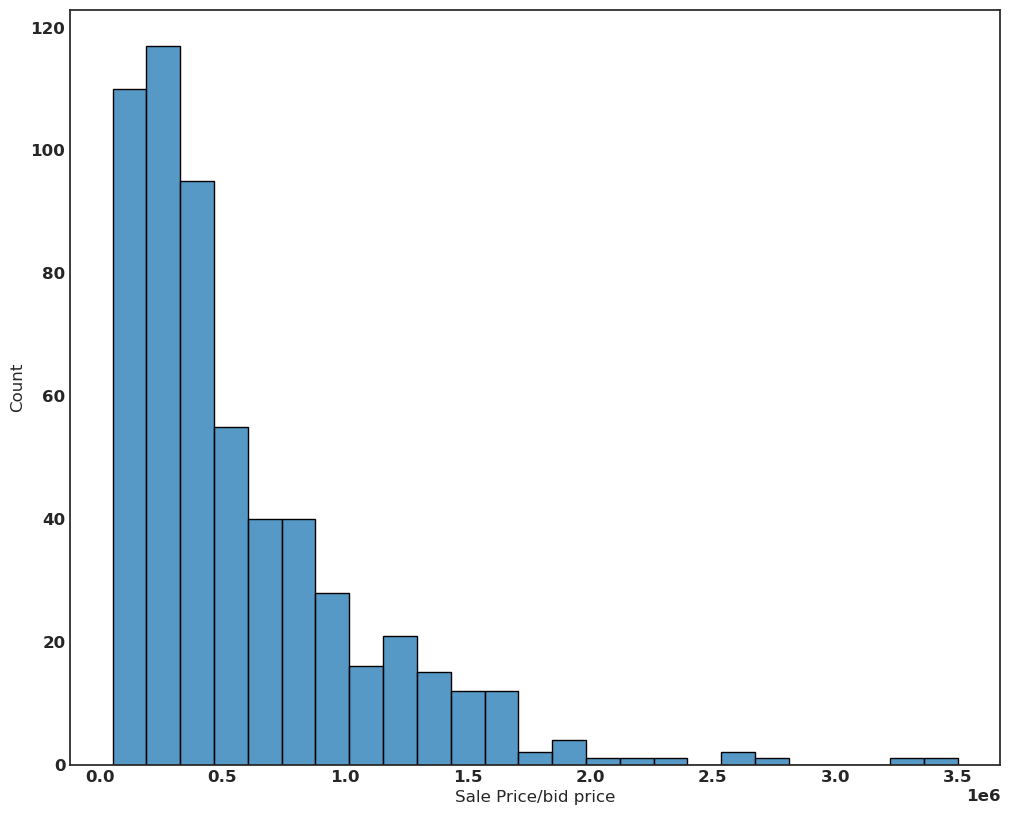

In [12]:
plt.figure(figsize=(12,10),dpi=100)
plt.grid(False)
sns.histplot(data['Sale Price/bid price'])

c:\Users\curti\Miniconda3\envs\youtube\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Sale Price/bid price'>

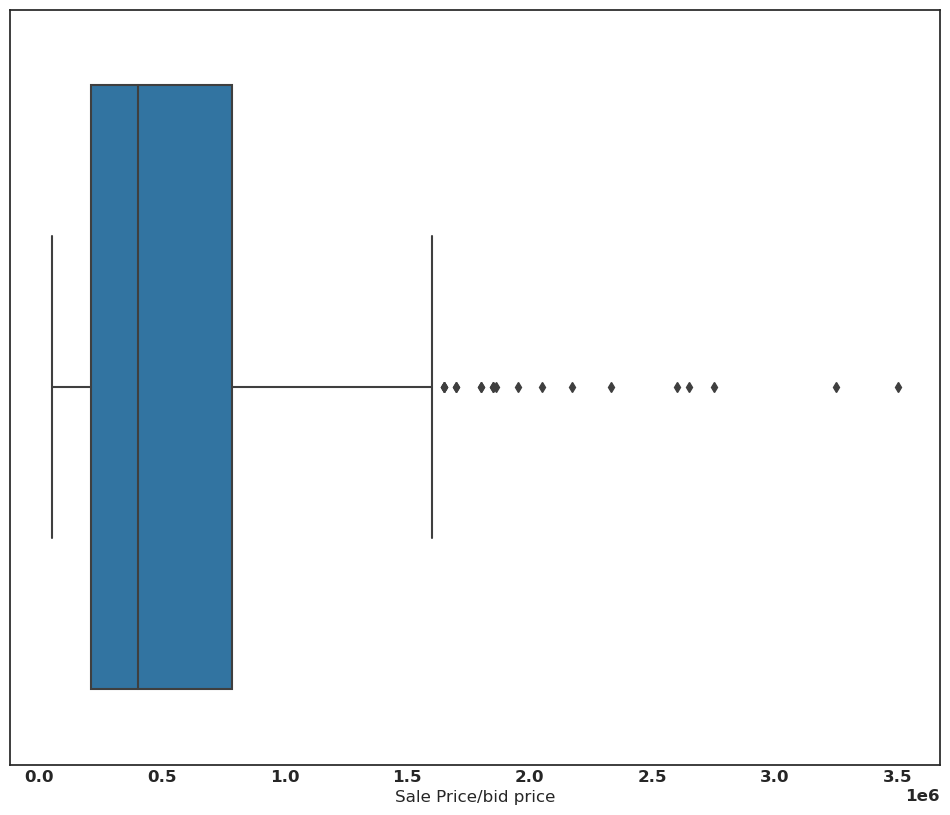

In [13]:
plt.figure(figsize=(12,10),dpi=100)
plt.grid(False)
sns.boxplot(data['Sale Price/bid price'])

<AxesSubplot:xlabel='Zillow Estimate', ylabel='Count'>

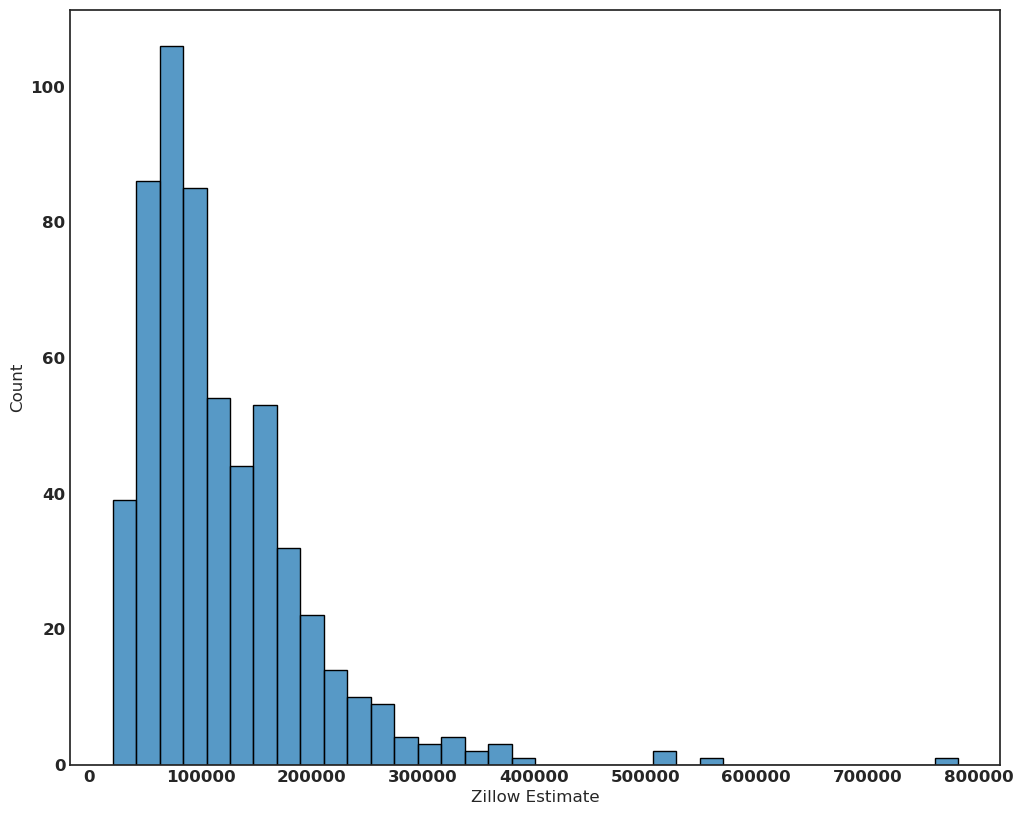

In [14]:
plt.figure(figsize=(12,10),dpi=100)
plt.grid(False)
sns.histplot(data['Zillow Estimate'])

c:\Users\curti\Miniconda3\envs\youtube\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Zillow Estimate'>

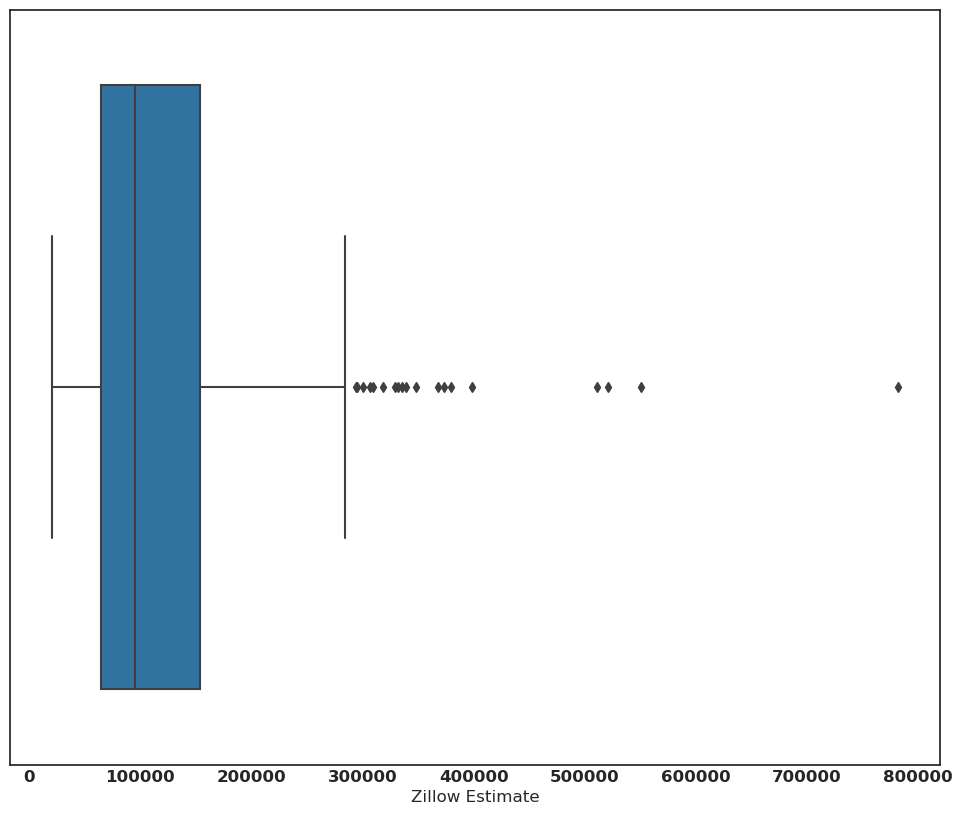

In [15]:
plt.figure(figsize=(12,10),dpi=100)
plt.grid(False)
sns.boxplot(data['Zillow Estimate'])

In [16]:
data.columns

Index(['Address', 'Zillow Address', 'Sale Date', 'Opening Bid',
       'Sale Price/bid price', 'Book/Writ', 'OPA', 'Postal Code', 'Attorney',
       'Ward', 'Seller', 'Buyer', 'Sheriff Cost', 'Advertising', 'Other',
       'Record Deed', 'Water', 'PGW', ' Avg Walk&Transit score  ',
       ' Violent Crime Rate ', ' School Score  ', 'Zillow Estimate',
       'Rent Estimate', 'taxAssessment', 'yearBuilt', 'finished \n(SqFt)',
       ' bathrooms ', ' bedrooms ', 'PropType', 'Average comps'],
      dtype='object')

In [17]:
data=data.rename(columns={
    'Zillow Estimate':'Zillow_Estimate',
    'Sheriff Cost':'Sheriff_Cost',
    'Rent Estimate':'Rent_Estimate',
    'finished \n(SqFt)':'SqFt',
    ' School Score  ':'School_Score',
    ' Avg Walk&Transit score  ':'Avg_Walk_Score',
    ' bedrooms ':'bedrooms',
    ' Violent Crime Rate ':'Violent_Crime_Rate',
    ' bathrooms ':'bathrooms',
    'Sale Price/bid price':'Sale_Bid_Price'})

In [18]:
data.columns

Index(['Address', 'Zillow Address', 'Sale Date', 'Opening Bid',
       'Sale_Bid_Price', 'Book/Writ', 'OPA', 'Postal Code', 'Attorney', 'Ward',
       'Seller', 'Buyer', 'Sheriff_Cost', 'Advertising', 'Other',
       'Record Deed', 'Water', 'PGW', 'Avg_Walk_Score', 'Violent_Crime_Rate',
       'School_Score', 'Zillow_Estimate', 'Rent_Estimate', 'taxAssessment',
       'yearBuilt', 'SqFt', 'bathrooms', 'bedrooms', 'PropType',
       'Average comps'],
      dtype='object')

In [19]:
cols = ['Zillow_Estimate','Sheriff_Cost','Rent_Estimate','SqFt','School_Score','Avg_Walk_Score','Violent_Crime_Rate','Water','bedrooms','bathrooms','Sale_Bid_Price']
data[cols].corr(method='pearson')

,Zillow_Estimate,Sheriff_Cost,Rent_Estimate,SqFt,School_Score,Avg_Walk_Score,Violent_Crime_Rate,Water,bedrooms,bathrooms,Sale_Bid_Price
Zillow_Estimate,1.000000,0.799720,0.867737,0.524208,0.454698,-0.477310,-0.462910,-0.011249,0.154938,0.485267,0.827967
Sheriff_Cost,0.799720,1.000000,0.658360,0.348054,0.493217,-0.420074,-0.445486,0.011491,0.078969,0.384920,0.979638
Rent_Estimate,0.867737,0.658360,1.000000,0.574183,0.285554,-0.351051,-0.301654,0.018629,0.248952,0.455474,0.692315
SqFt,0.524208,0.348054,0.574183,1.000000,0.145085,-0.205343,-0.140638,0.052084,0.597551,0.439865,0.362912
School_Score,0.454698,0.493217,0.285554,0.145085,1.000000,-0.697751,-0.540658,0.026656,-0.079304,0.318826,0.512068
Avg_Walk_Score,-0.477310,-0.420074,-0.351051,-0.205343,-0.697751,1.000000,0.532836,0.008478,-0.016037,-0.367710,-0.433764
Violent_Crime_Rate,-0.462910,-0.445486,-0.301654,-0.140638,-0.540658,0.532836,1.000000,0.034014,0.027958,-0.260084,-0.445249
Water,-0.011249,0.011491,0.018629,0.052084,0.026656,0.008478,0.034014,1.000000,-0.011165,-0.019692,0.030284
bedrooms,0.154938,0.078969,0.248952,0.597551,-0.079304,-0.016037,0.027958,-0.011165,1.000000,0.241235,0.073283
bathrooms,0.485267,0.384920,0.455474,0.439865,0.318826,-0.367710,-0.260084,-0.019692,0.241235,1.000000,0.400876


In [20]:
data

,Address,Zillow Address,Sale Date,Opening Bid,Sale_Bid_Price,Book/Writ,OPA,Postal Code,Attorney,Ward,...,School_Score,Zillow_Estimate,Rent_Estimate,taxAssessment,yearBuilt,SqFt,bathrooms,bedrooms,PropType,Average comps
0,2327 E SERGEANT ST,2327 E SERGEANT ST Philadelphia PA 19125,September 13 2016,11400.0,114000.0,1609-412,314095100.0,19125.0,PHELAN HALLINAN LLP,31.0,...,15.87,228663.0,1500.0,174000.00,1921.0,898.0,1.0,2.0,SingleFamily,240254.55
1,4466 TOLBUT ST,4466 TOLBUT ST Philadelphia PA 19136,August 2 2016,8500.0,85000.0,1606-339,652092800.0,19136.0,PARKER MCCAY,65.0,...,32.53,141579.0,1200.0,119700.00,1959.0,1120.0,1.5,3.0,Townhouse,150937.50
2,134 E WALNUT LN,134 E WALNUT LN Philadelphia PA 19144,August 2 2016,12600.0,126000.0,1605-426,592058735.0,19144.0,PHELAN HALLINAN LLP,59.0,...,7.89,186172.0,1500.0,190300.00,2006.0,1882.0,3.0,3.0,SingleFamily,225483.33
3,111 W ABBOTTSFORD AVE,111 W ABBOTTSFORD AVE Philadelphia PA 19144,August 2 2016,9200.0,92000.0,1607-317,123016300.0,19144.0,KML LAW GROUP,12.0,...,7.89,168557.0,1400.0,118300.00,1900.0,1792.0,1.0,4.0,SingleFamily,135755.56
4,146 E DUVAL ST,146 E DUVAL ST Philadelphia PA 19144,August 2 2016,8900.0,89000.0,1605-510,592159100.0,19144.0,PHELAN HALLINAN LLP,59.0,...,7.89,135045.0,1350.0,113700.00,1925.0,1419.0,2.0,3.0,SingleFamily,144120.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,2210 N 17TH ST,2210 N 17TH ST Philadelphia PA 19132,September 13 2016,7400.0,590000.0,1609-400,161161901.0,19132.0,SHAPIRO & DENARDO LLC,16.0,...,5.63,61406.0,1250.0,13400.00,1936.0,2288.0,1.0,5.0,Townhouse,72625.00
611,31 N RUBY ST,31 N RUBY ST Philadelphia PA 19139,October 4 2016,64800.0,648000.0,1610-567,441192200.0,19139.0,MILSTEAD & ASSOCIATES LLC,44.0,...,3.34,59447.0,1100.0,43900.00,1925.0,1238.0,1.0,3.0,Townhouse,56029.00
612,653 N 33RD ST,653 N 33RD ST Philadelphia PA 19104,August 2 2016,15100.0,250000.0,1602-655,242143100.0,19104.0,MCCABE WEISBERG & CONWAY P.C.,24.0,...,28.40,20806.0,1300.0,16200.00,1935.0,2315.0,4.0,5.0,MultiFamily2To4,21166.67
613,5423 WOODBINE AVE,5423 WOODBINE AVE Philadelphia PA 19131,August 2 2016,15400.0,1800000.0,1608-406,522177800.0,19131.0,STERN & EISENBERG P.C.,52.0,...,8.34,83447.0,1450.0,65700.00,1925.0,3096.0,2.0,6.0,SingleFamily,126401.60


<AxesSubplot:>

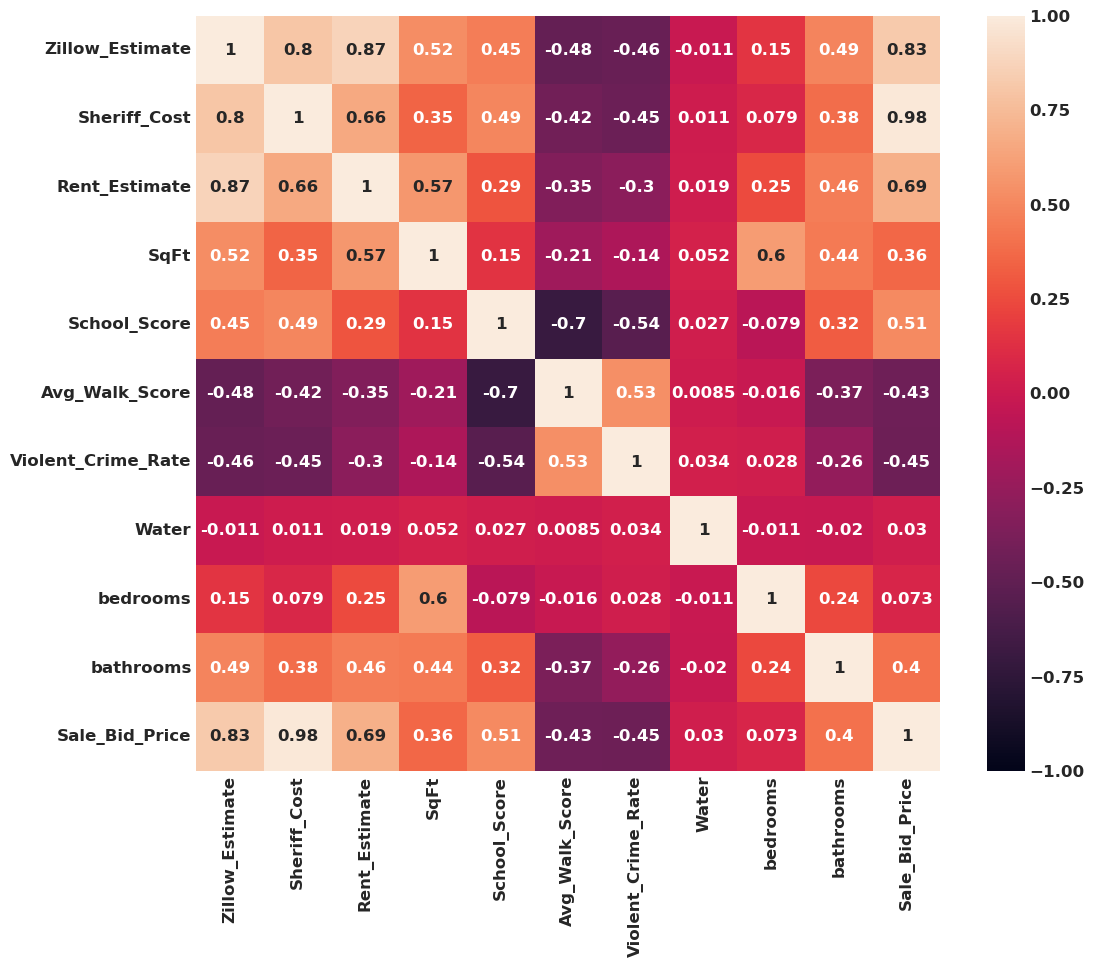

In [21]:
plt.figure(figsize=(12,10),dpi=100)
plt.grid(False)
sns.heatmap(data[cols].corr(),vmin=-1.0,vmax=1.0,annot=True)

<AxesSubplot:xlabel='Avg_Walk_Score', ylabel='Count'>

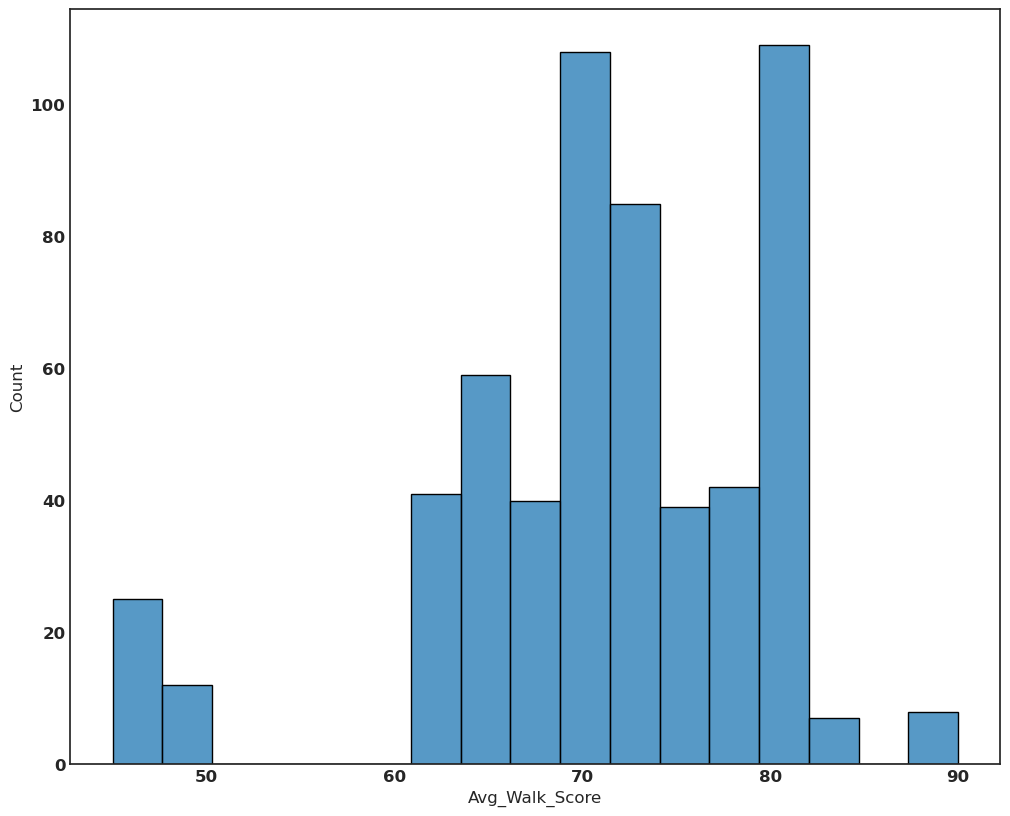

In [22]:
plt.figure(figsize=(12,10),dpi=100)
plt.grid(False)
sns.histplot(data['Avg_Walk_Score'])

<AxesSubplot:xlabel='Violent_Crime_Rate', ylabel='Count'>

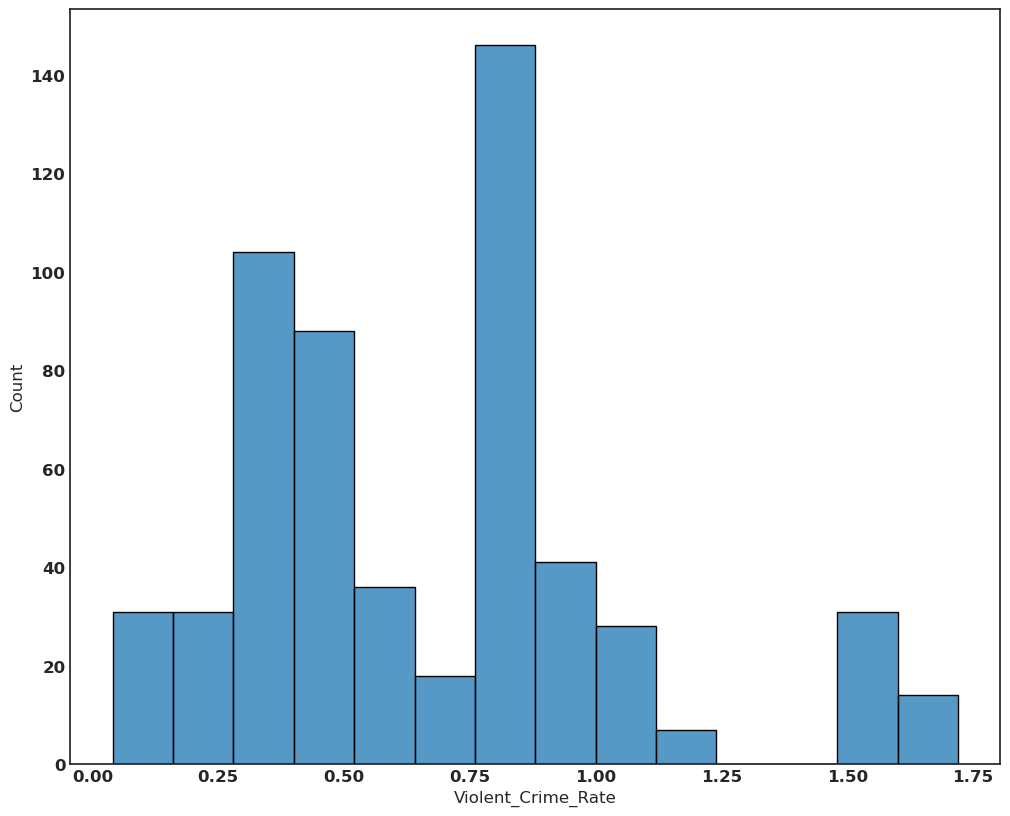

In [23]:
plt.figure(figsize=(12,10),dpi=100)
plt.grid(False)
sns.histplot(data['Violent_Crime_Rate'])

<AxesSubplot:xlabel='Avg_Walk_Score', ylabel='Zillow_Estimate'>

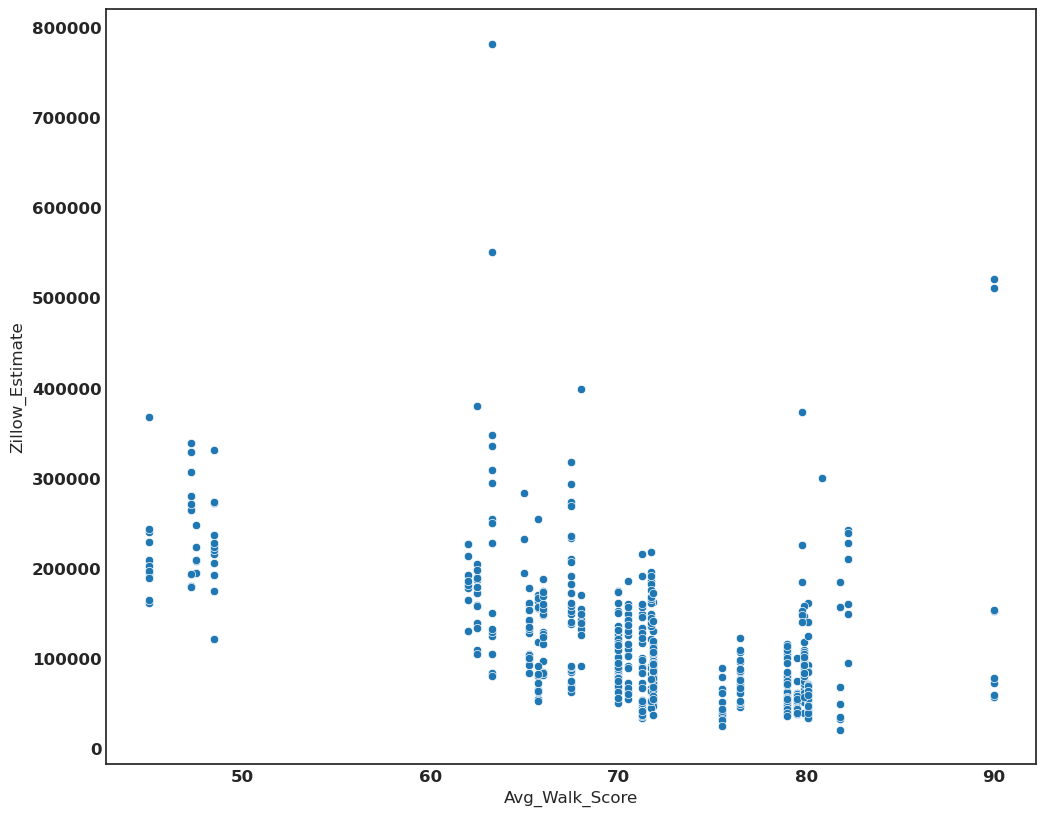

In [24]:
plt.figure(figsize=(12,10),dpi=100)
plt.grid(False)
sns.scatterplot(x='Avg_Walk_Score',y='Zillow_Estimate',data=data)

<AxesSubplot:xlabel='Avg_Walk_Score', ylabel='Zillow_Estimate'>

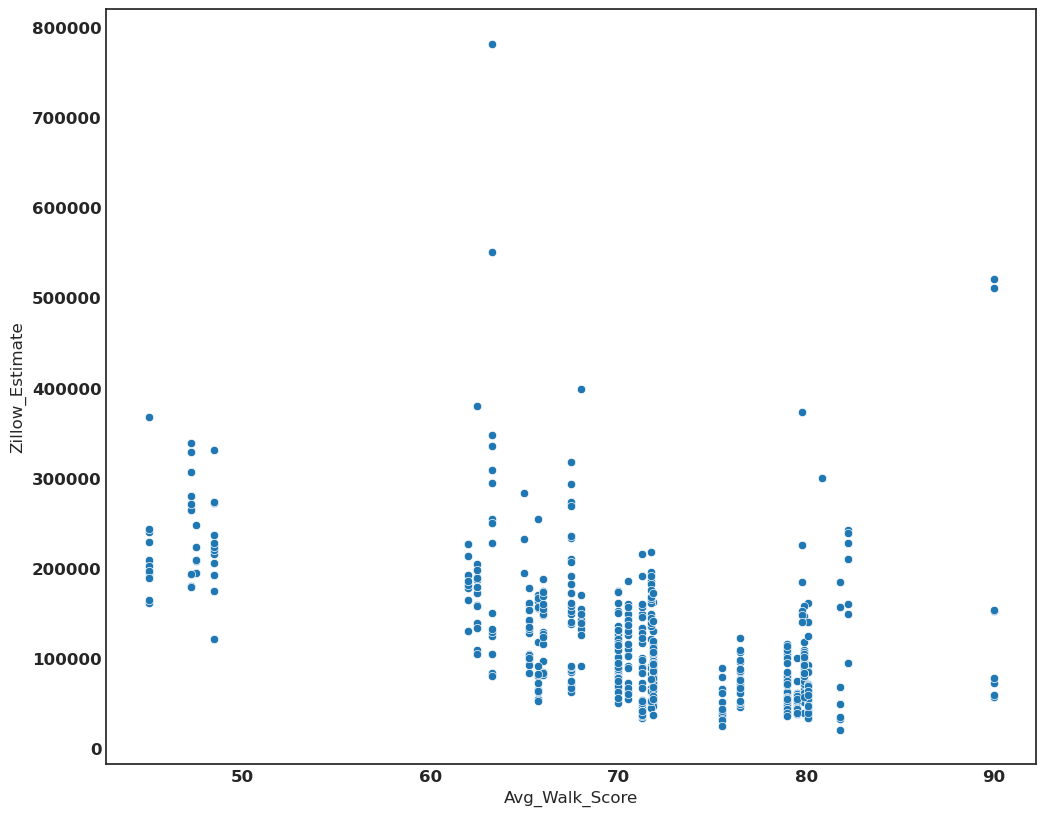

In [25]:
plt.figure(figsize=(12,10),dpi=100)
plt.grid(False)
sns.scatterplot(x='Avg_Walk_Score',y='Zillow_Estimate',data=data)

<AxesSubplot:xlabel='SqFt', ylabel='Zillow_Estimate'>

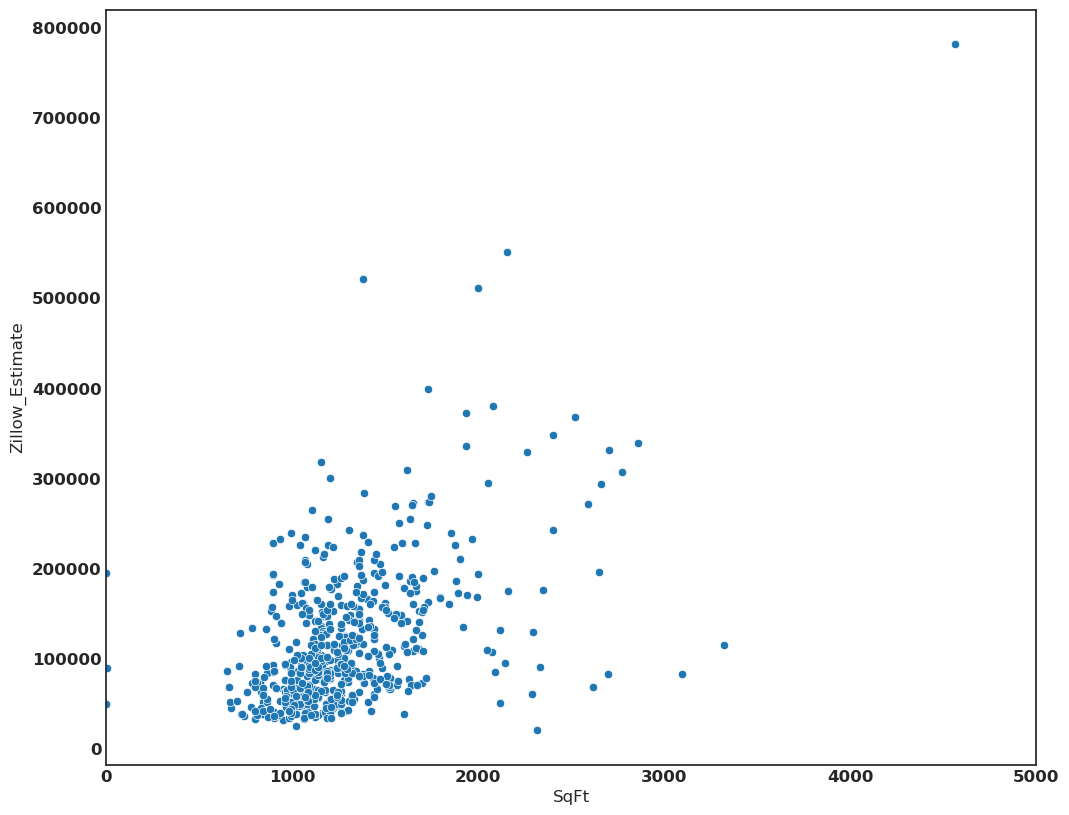

In [26]:
plt.figure(figsize=(12,10),dpi=100)
plt.grid(False)
plt.xlim([0,5000])
sns.scatterplot(x='SqFt',y='Zillow_Estimate',data=data)

<AxesSubplot:xlabel='Sheriff_Cost', ylabel='Zillow_Estimate'>

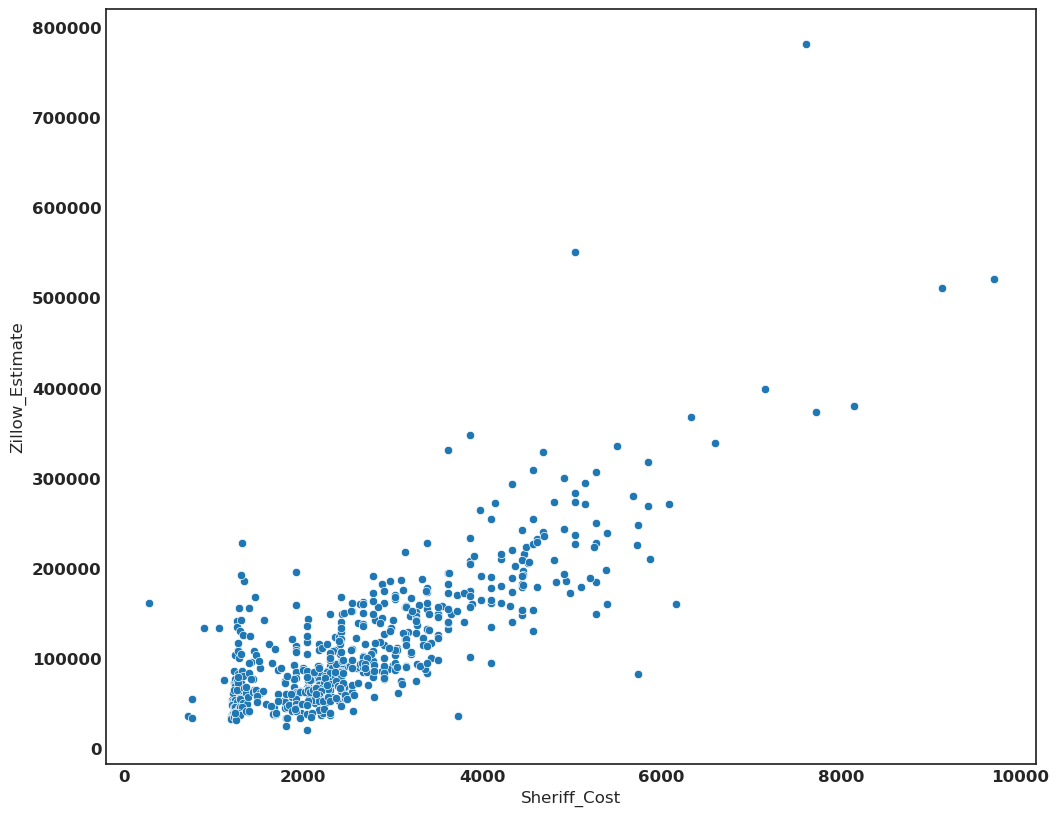

In [27]:
plt.figure(figsize=(12,10),dpi=100)
plt.grid(False)
#plt.xticks(rotation=90)
sns.scatterplot(x='Sheriff_Cost',y='Zillow_Estimate',data=data)

<AxesSubplot:xlabel='Violent_Crime_Rate', ylabel='Zillow_Estimate'>

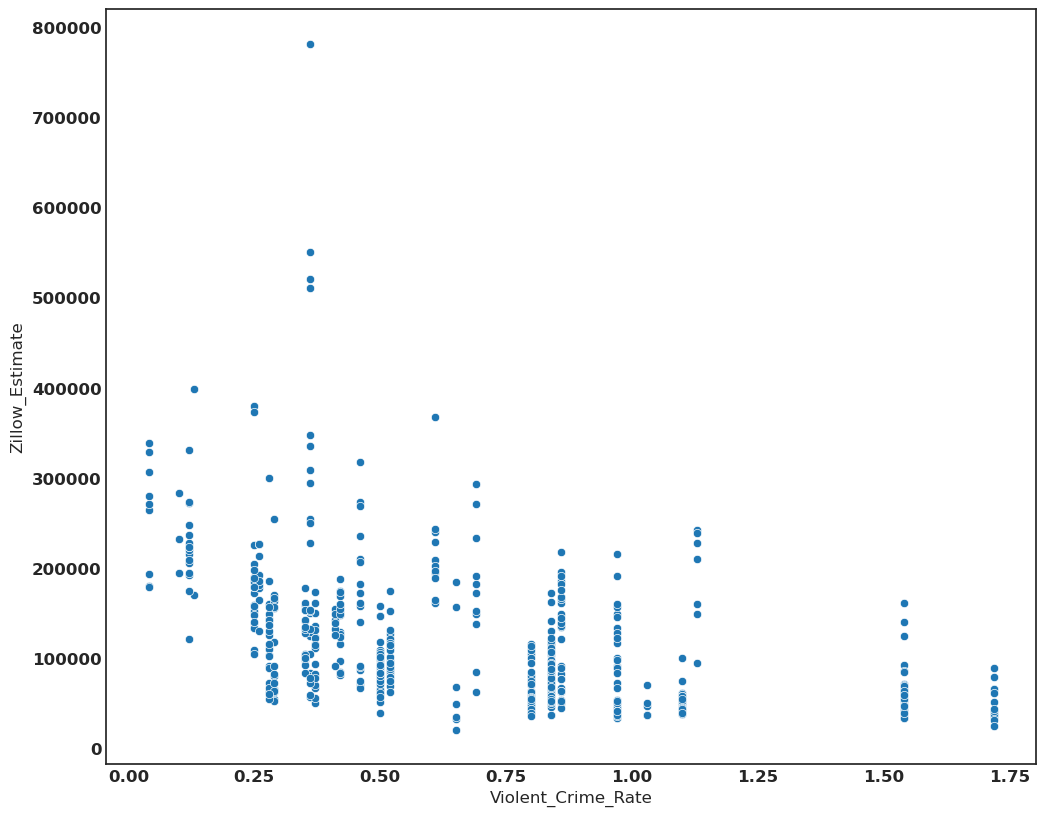

In [28]:
plt.figure(figsize=(12,10),dpi=100)
plt.grid(False)
#plt.xticks(rotation=90)
sns.scatterplot(x='Violent_Crime_Rate',y='Zillow_Estimate',data=data)

In [29]:
data

,Address,Zillow Address,Sale Date,Opening Bid,Sale_Bid_Price,Book/Writ,OPA,Postal Code,Attorney,Ward,...,School_Score,Zillow_Estimate,Rent_Estimate,taxAssessment,yearBuilt,SqFt,bathrooms,bedrooms,PropType,Average comps
0,2327 E SERGEANT ST,2327 E SERGEANT ST Philadelphia PA 19125,September 13 2016,11400.0,114000.0,1609-412,314095100.0,19125.0,PHELAN HALLINAN LLP,31.0,...,15.87,228663.0,1500.0,174000.00,1921.0,898.0,1.0,2.0,SingleFamily,240254.55
1,4466 TOLBUT ST,4466 TOLBUT ST Philadelphia PA 19136,August 2 2016,8500.0,85000.0,1606-339,652092800.0,19136.0,PARKER MCCAY,65.0,...,32.53,141579.0,1200.0,119700.00,1959.0,1120.0,1.5,3.0,Townhouse,150937.50
2,134 E WALNUT LN,134 E WALNUT LN Philadelphia PA 19144,August 2 2016,12600.0,126000.0,1605-426,592058735.0,19144.0,PHELAN HALLINAN LLP,59.0,...,7.89,186172.0,1500.0,190300.00,2006.0,1882.0,3.0,3.0,SingleFamily,225483.33
3,111 W ABBOTTSFORD AVE,111 W ABBOTTSFORD AVE Philadelphia PA 19144,August 2 2016,9200.0,92000.0,1607-317,123016300.0,19144.0,KML LAW GROUP,12.0,...,7.89,168557.0,1400.0,118300.00,1900.0,1792.0,1.0,4.0,SingleFamily,135755.56
4,146 E DUVAL ST,146 E DUVAL ST Philadelphia PA 19144,August 2 2016,8900.0,89000.0,1605-510,592159100.0,19144.0,PHELAN HALLINAN LLP,59.0,...,7.89,135045.0,1350.0,113700.00,1925.0,1419.0,2.0,3.0,SingleFamily,144120.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,2210 N 17TH ST,2210 N 17TH ST Philadelphia PA 19132,September 13 2016,7400.0,590000.0,1609-400,161161901.0,19132.0,SHAPIRO & DENARDO LLC,16.0,...,5.63,61406.0,1250.0,13400.00,1936.0,2288.0,1.0,5.0,Townhouse,72625.00
611,31 N RUBY ST,31 N RUBY ST Philadelphia PA 19139,October 4 2016,64800.0,648000.0,1610-567,441192200.0,19139.0,MILSTEAD & ASSOCIATES LLC,44.0,...,3.34,59447.0,1100.0,43900.00,1925.0,1238.0,1.0,3.0,Townhouse,56029.00
612,653 N 33RD ST,653 N 33RD ST Philadelphia PA 19104,August 2 2016,15100.0,250000.0,1602-655,242143100.0,19104.0,MCCABE WEISBERG & CONWAY P.C.,24.0,...,28.40,20806.0,1300.0,16200.00,1935.0,2315.0,4.0,5.0,MultiFamily2To4,21166.67
613,5423 WOODBINE AVE,5423 WOODBINE AVE Philadelphia PA 19131,August 2 2016,15400.0,1800000.0,1608-406,522177800.0,19131.0,STERN & EISENBERG P.C.,52.0,...,8.34,83447.0,1450.0,65700.00,1925.0,3096.0,2.0,6.0,SingleFamily,126401.60


In [30]:
data['Walk_Class'] = pd.qcut(data['Avg_Walk_Score'],q=5,labels=['Car Dependent','Somewhat Car Dependent','Somewhat Walkable','Walkable','Walkers Paradise'])

In [31]:
data['Crime_Class'] = pd.qcut(data['Violent_Crime_Rate'],q=4, labels=['Low crime','Medium crime','High crime','Extrem crime'])

<AxesSubplot:xlabel='Walk_Class', ylabel='Zillow_Estimate'>

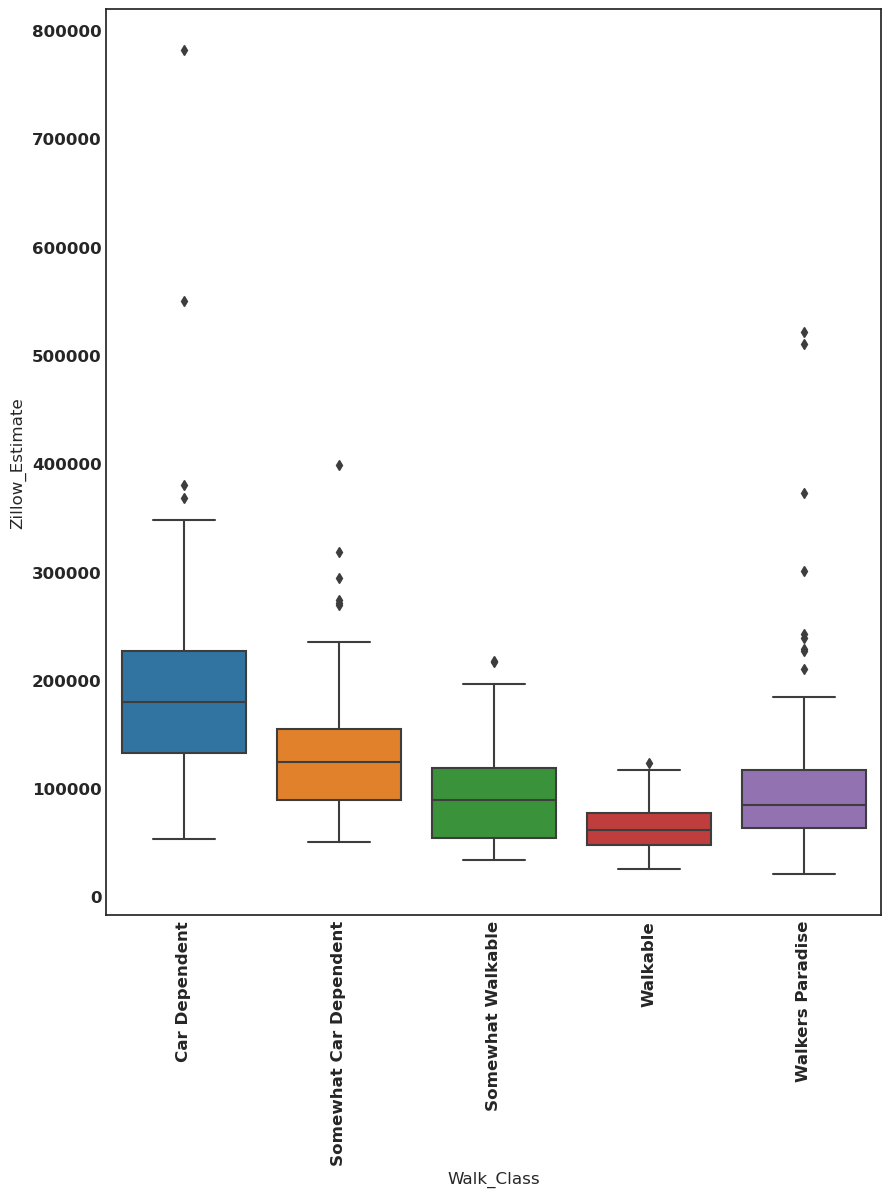

In [32]:
plt.figure(figsize=(10,12),dpi=100)
plt.grid(False)
plt.xticks(rotation=90)
sns.boxplot(x='Walk_Class',y='Zillow_Estimate',data=data)

<AxesSubplot:xlabel='Walk_Class', ylabel='Sale_Bid_Price'>

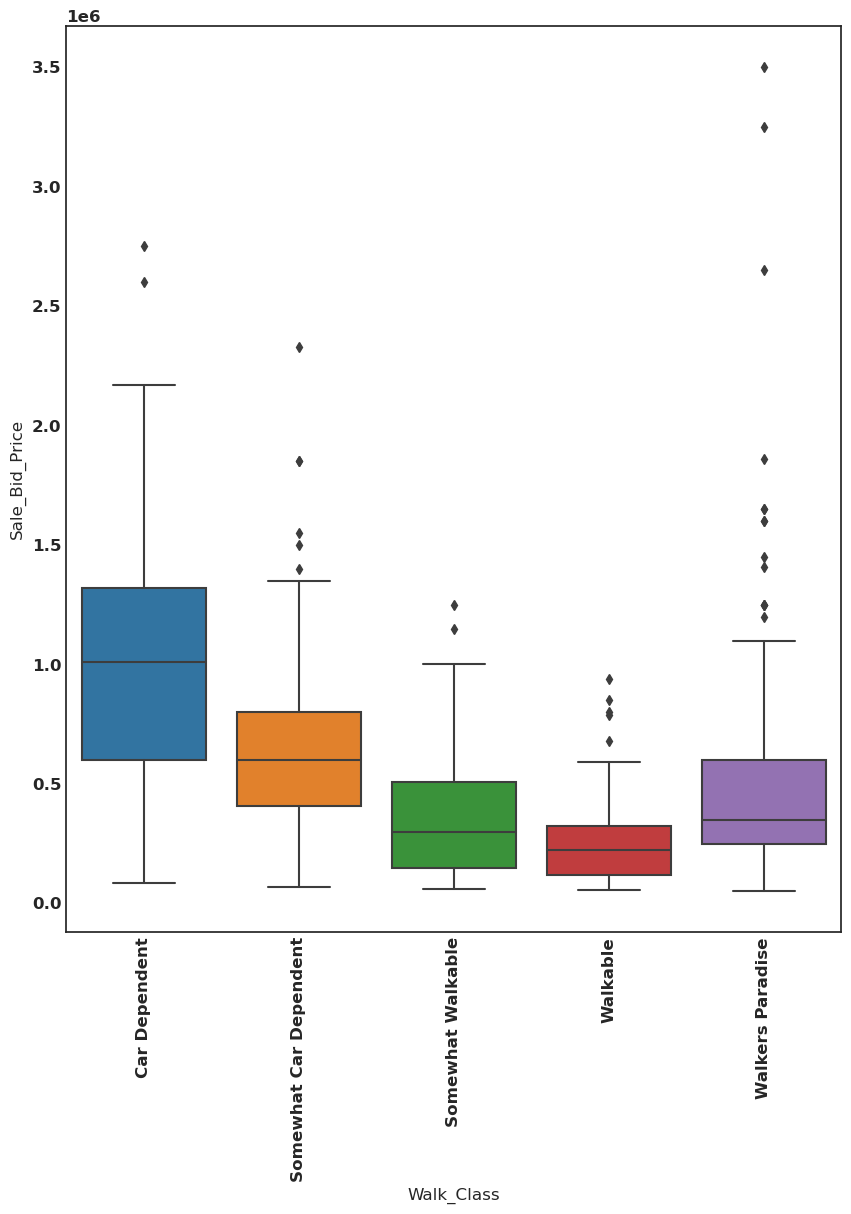

In [33]:
plt.figure(figsize=(10,12),dpi=100)
plt.grid(False)
plt.xticks(rotation=90)
sns.boxplot(x='Walk_Class',y='Sale_Bid_Price',data=data)

<AxesSubplot:xlabel='PropType', ylabel='Sale_Bid_Price'>

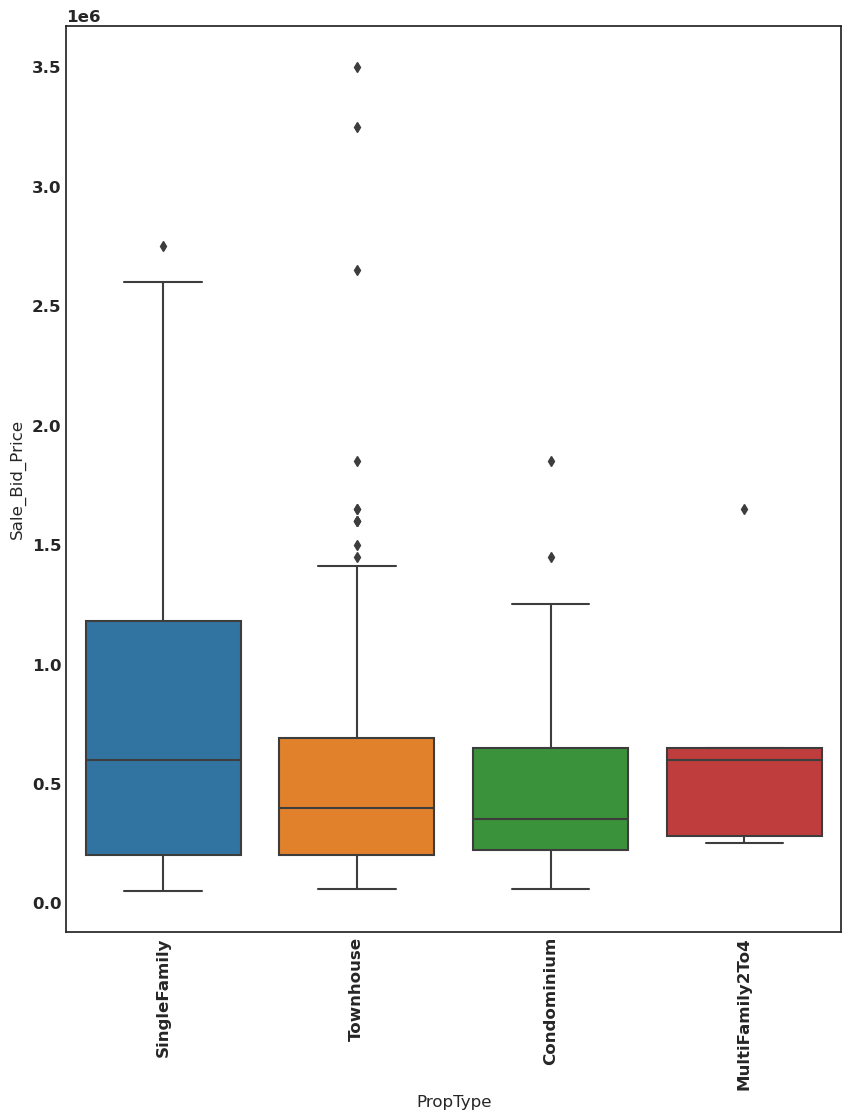

In [34]:
plt.figure(figsize=(10,12),dpi=100)
plt.grid(False)
plt.xticks(rotation=90)
sns.boxplot(x='PropType',y='Sale_Bid_Price',data=data)

<AxesSubplot:xlabel='PropType', ylabel='Zillow_Estimate'>

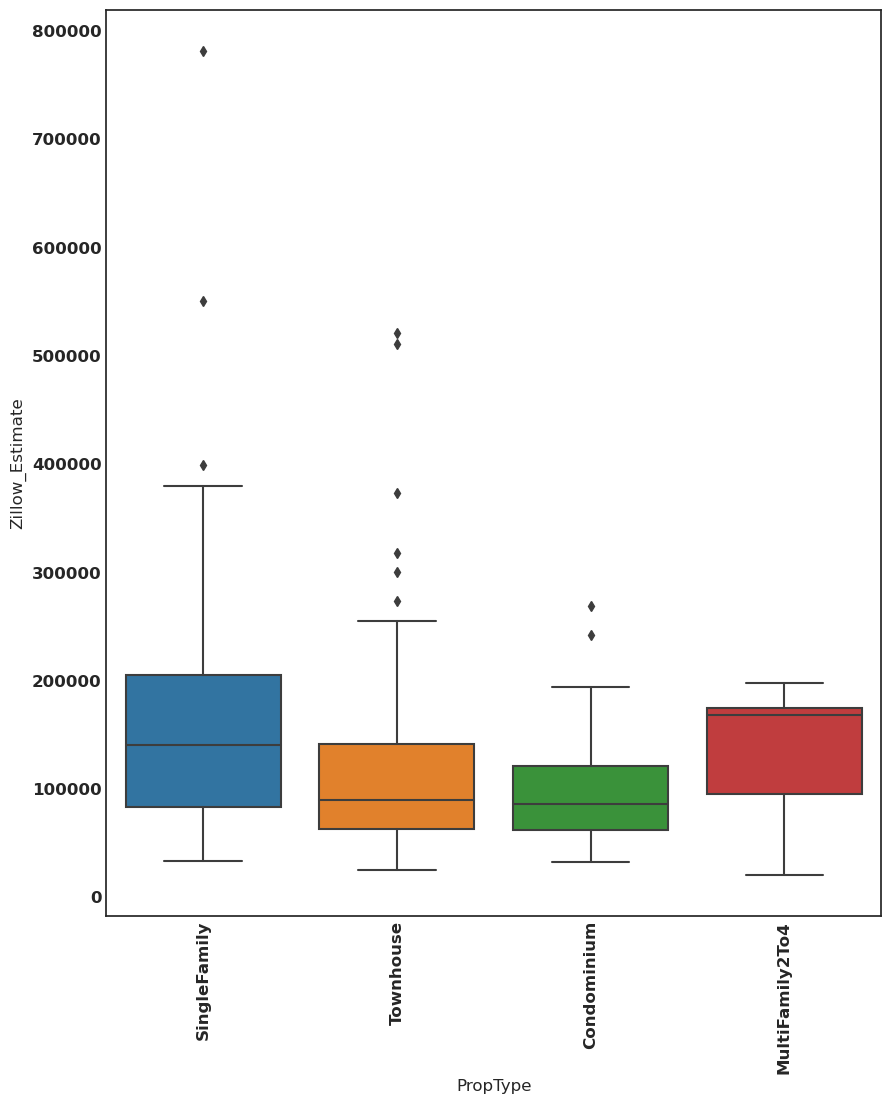

In [35]:
plt.figure(figsize=(10,12),dpi=100)
plt.grid(False)
plt.xticks(rotation=90)
sns.boxplot(x='PropType',y='Zillow_Estimate',data=data)

<AxesSubplot:xlabel='Crime_Class', ylabel='Zillow_Estimate'>

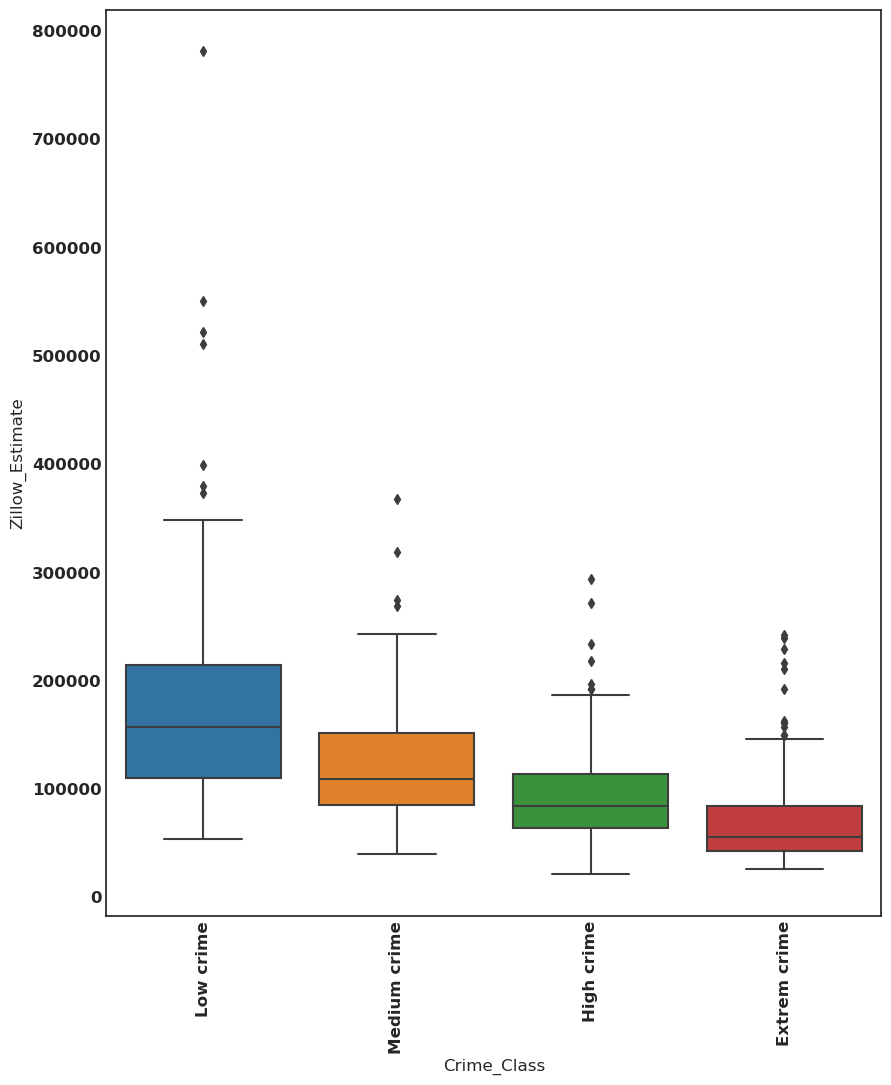

In [36]:
plt.figure(figsize=(10,12),dpi=100)
plt.grid(False)
plt.xticks(rotation=90)
sns.boxplot(x='Crime_Class',y='Zillow_Estimate',data=data)

In [37]:
data.columns

Index(['Address', 'Zillow Address', 'Sale Date', 'Opening Bid',
       'Sale_Bid_Price', 'Book/Writ', 'OPA', 'Postal Code', 'Attorney', 'Ward',
       'Seller', 'Buyer', 'Sheriff_Cost', 'Advertising', 'Other',
       'Record Deed', 'Water', 'PGW', 'Avg_Walk_Score', 'Violent_Crime_Rate',
       'School_Score', 'Zillow_Estimate', 'Rent_Estimate', 'taxAssessment',
       'yearBuilt', 'SqFt', 'bathrooms', 'bedrooms', 'PropType',
       'Average comps', 'Walk_Class', 'Crime_Class'],
      dtype='object')

In [38]:
model_data = data[['Zillow_Estimate','SqFt', 'Walk_Class',  'bathrooms',  'bedrooms',  'School_Score',  'Crime_Class', 'PropType','Sheriff_Cost']]

In [39]:
Formula = "Zillow_Estimate ~ SqFt + C(Walk_Class) + bathrooms + bedrooms + School_Score + C(Crime_Class) + C(PropType) "
reg = smf.ols(formula=Formula,data=model_data).fit()

In [40]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Zillow_Estimate   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     48.83
Date:                Sun, 20 Nov 2022   Prob (F-statistic):           1.92e-87
Time:                        12:29:50   Log-Likelihood:                -7064.0
No. Observations:                 575   AIC:                         1.416e+04
Df Residuals:                     560   BIC:                         1.422e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                5.425e+04   1.52e+04      3.572      0.000    2.44e+04    8.41e+04
C(Walk_Class)[T.Somewhat Car Dependent] -1120.6954   9960.661     -0.113      0.910   -2.07e+04    1.84e+04
C(Walk_Class)[T.Somewhat Walkable]       -1.83e+04   1.36e+04     -1.350      0.178   -4.49e+04    8324.746
C(Walk_Class)[T.Walkable]               -3.338e+04   1.42e+04     -2.353      0.019   -6.12e+04   -5521.323
C(Walk_Class)[T.Walkers Paradise]       -1.028e+04   1.09e+04     -0.946      0.345   -3.16e+04    1.11e+04
C(Crime_Class)[T.Medium crime]           -2.42e+04   8333.481     -2.904      0.004   -4.06e+04   -7830.472
C(Crime_Class)[T.High crime]            -3.058e+04    1.2e+04     -2.555      0.011   -5.41e+04   -7074.725
C(Crime_Class)[T.Extrem crime]          -3.638e+04   1.14e+04     -3.204      0.001   -5.87e+04   -1.41e+04
C(PropType)[T.MultiFamily2To4]          -8.658e+04   2.53e+04     -3.424      0.001   -1.36e+05   -3.69e+04
C(PropType)[T.SingleFamily]               1.14e+04   6449.677      1.768      0.078   -1266.802    2.41e+04
C(PropType)[T.Townhouse]                  713.4828   5504.375      0.130      0.897   -1.01e+04    1.15e+04
SqFt                                       88.3989      7.624     11.595      0.000      73.424     103.374
bathrooms                                2.248e+04   3933.623      5.714      0.000    1.48e+04    3.02e+04
bedrooms                                -1.946e+04   4354.235     -4.469      0.000    -2.8e+04   -1.09e+04
School_Score                              884.9719    266.184      3.325      0.001     362.131    1407.813
==============================================================================
Omnibus:                      245.031   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2242.030
Skew:                           1.632   Prob(JB):                         0.00
Kurtosis:                      12.106   Cond. No.                     1.64e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.64e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

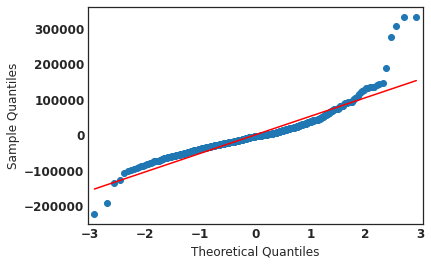

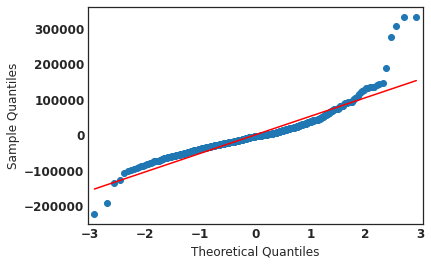

In [41]:
residuals = reg.resid
standard_norm=np.random.normal(size=150)
sm.ProbPlot(residuals).qqplot(line='s')

Text(0.5, 1.0, 'Residual Histogram')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


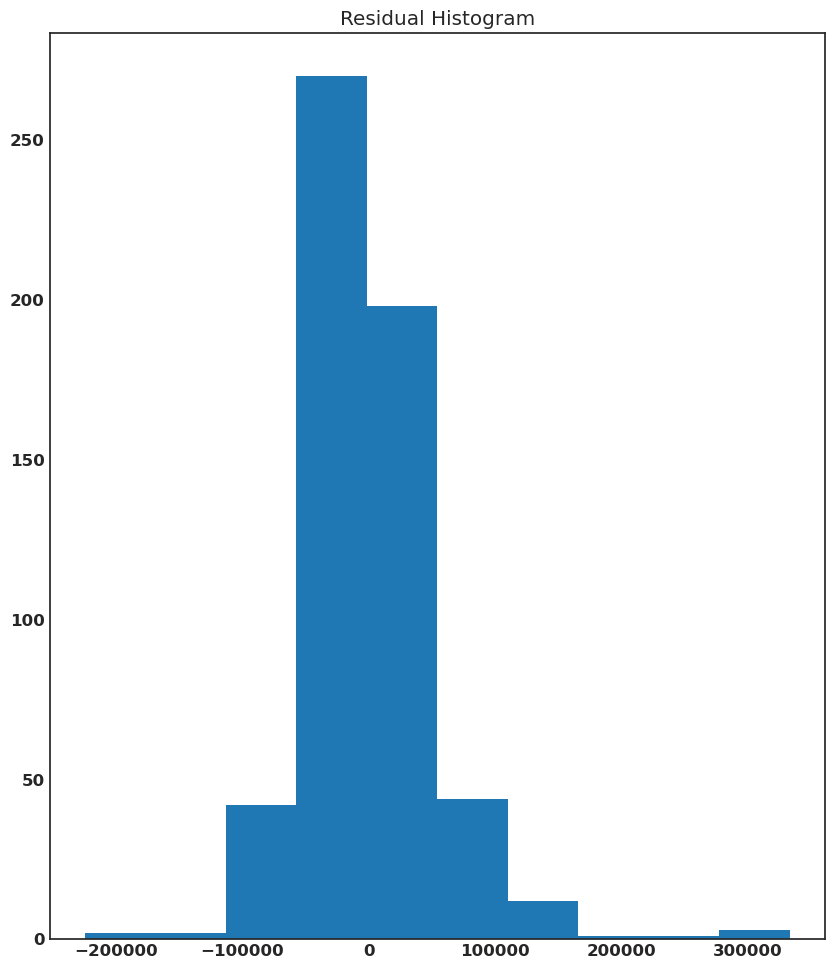

In [42]:
plt.figure(figsize=(10,12),dpi=100)
plt.hist(residuals)
plt.title("Residual Histogram")

In [658]:
(residuals).mean()

-2.6179706843623474e-09

Text(0.5, 0, 'Fitted Values')

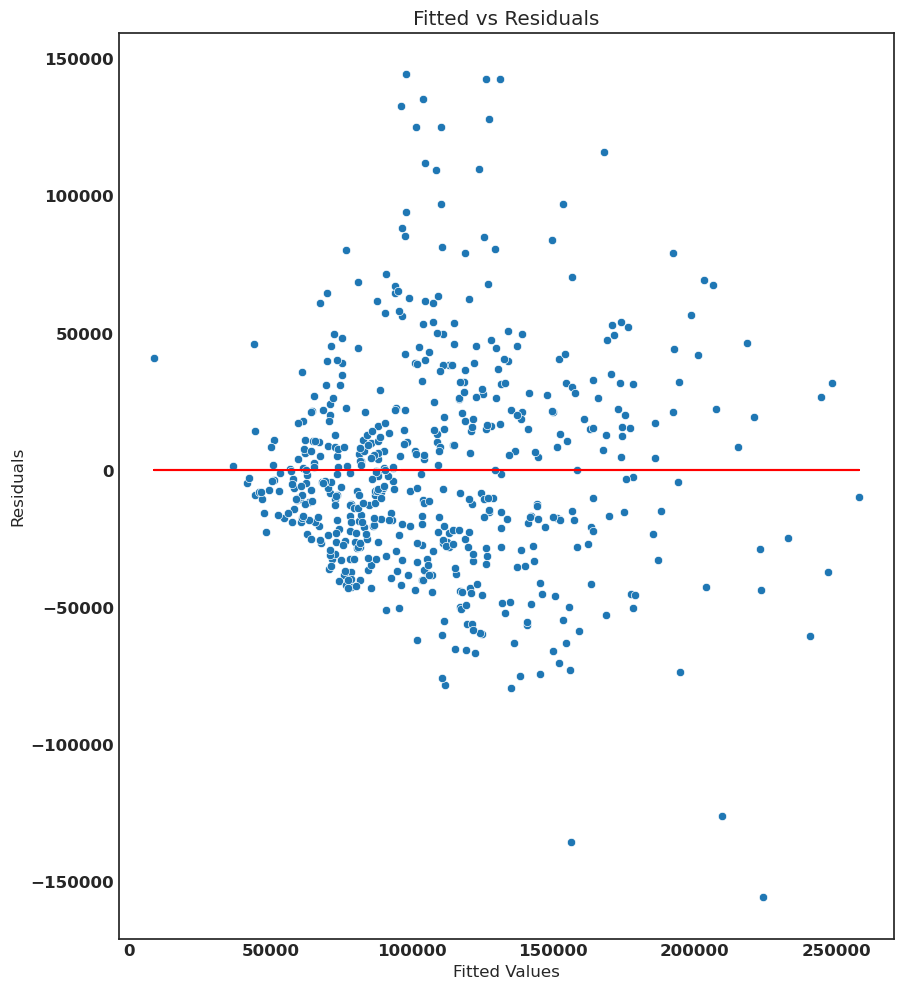

In [659]:
fitted_values = reg.fittedvalues
plt.figure(figsize=(10,12),dpi=100)
mean=residuals.mean()
mean_vec =np.full(residuals.shape,mean)
plt.plot(fitted_values,mean_vec,color='r')
sns.scatterplot(x=fitted_values,y=residuals)
plt.title("Fitted vs Residuals")
plt.ylabel('Residuals')
plt.xlabel('Fitted Values')

In [43]:
stats.boxcox(model_data['Zillow_Estimate'])

(array([5.79719165, 5.71214578, 5.76143371, 5.74376429, 5.70344367,
        5.70182915, 5.76726645, 5.7296796 , 5.71308941, 5.64025226,
        5.65365168, 5.69673277, 5.58432412, 5.66335405, 5.6764109 ,
        5.61746524, 5.61061755, 5.66177441, 5.59676263, 5.69076132,
        5.72958898, 5.52264245, 5.58139278, 5.5851583 , 5.64844987,
        5.55146341, 5.56437751, 5.57359504, 5.56196396, 5.55527659,
        5.65545791, 5.51526353, 5.52004027, 5.77076722, 5.50508022,
        5.52103366, 5.58907978, 5.68973578, 5.73417852, 5.5847417 ,
        5.61894723, 5.56007038, 5.50816091, 5.42738328, 5.60473957,
        5.49899226, 5.44856578, 5.49230564, 5.62462559, 5.50521299,
        5.66271873, 5.60159392, 5.56957908, 5.51610125, 5.61280025,
        5.7132646 , 5.4553449 , 5.49722221, 5.49230564, 5.45304766,
        5.55259799, 5.6373904 , 5.44557186, 5.67183357, 5.71524911,
        5.53257255, 5.48526305, 5.46866841, 5.65416551, 5.4184095 ,
        5.54846688, 5.52880496, 5.5959041 , 5.66

Text(0.5, 0, 'bathrooms')

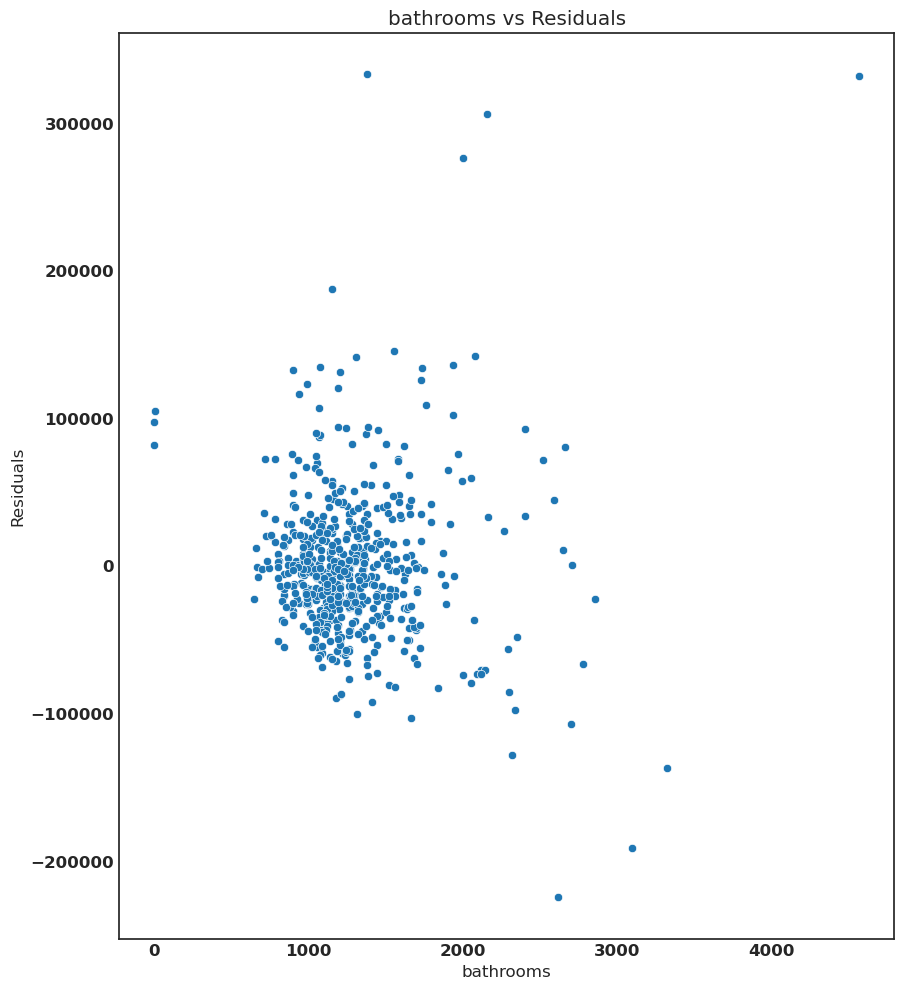

In [44]:
plt.figure(figsize=(10,12),dpi=100)
sns.scatterplot(x=model_data['SqFt'],y=residuals)
plt.title('bathrooms vs Residuals')
plt.ylabel("Residuals")
plt.xlabel('bathrooms')

In [45]:
model_data = remove_outliers(model_data,cols=['Zillow_Estimate'])

<AxesSubplot:>

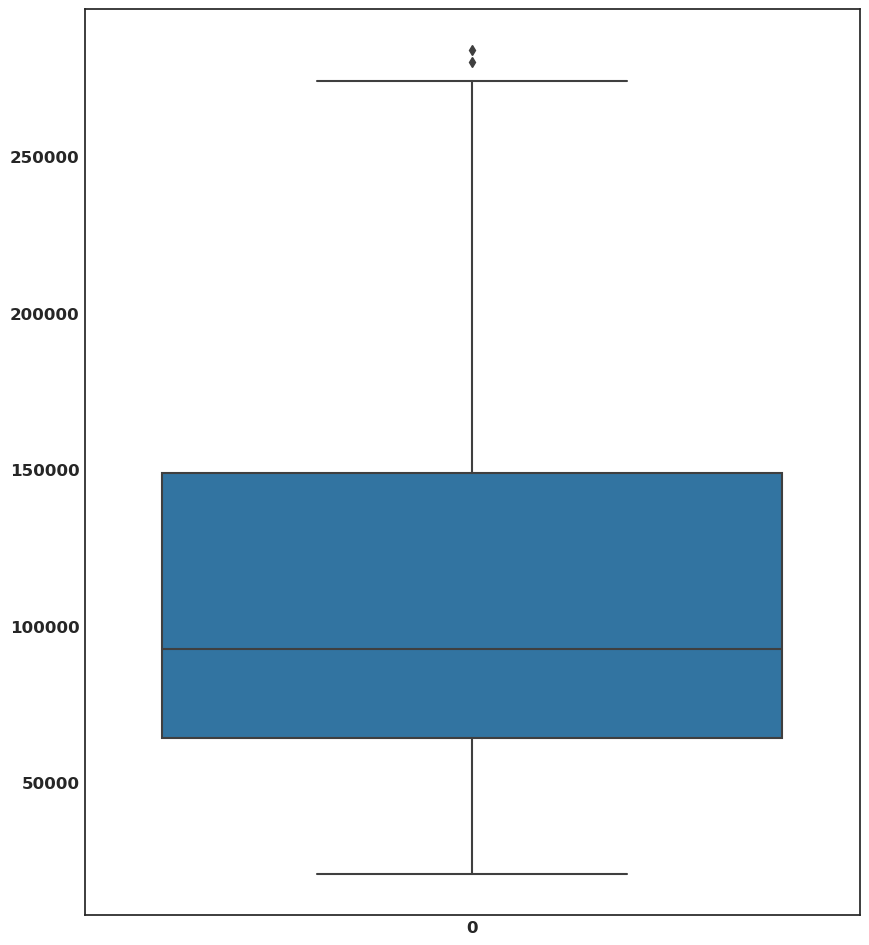

In [46]:
plt.figure(figsize=(10,12),dpi=100)
sns.boxplot(data=model_data['Zillow_Estimate'])

<AxesSubplot:xlabel='Zillow_Estimate', ylabel='Count'>

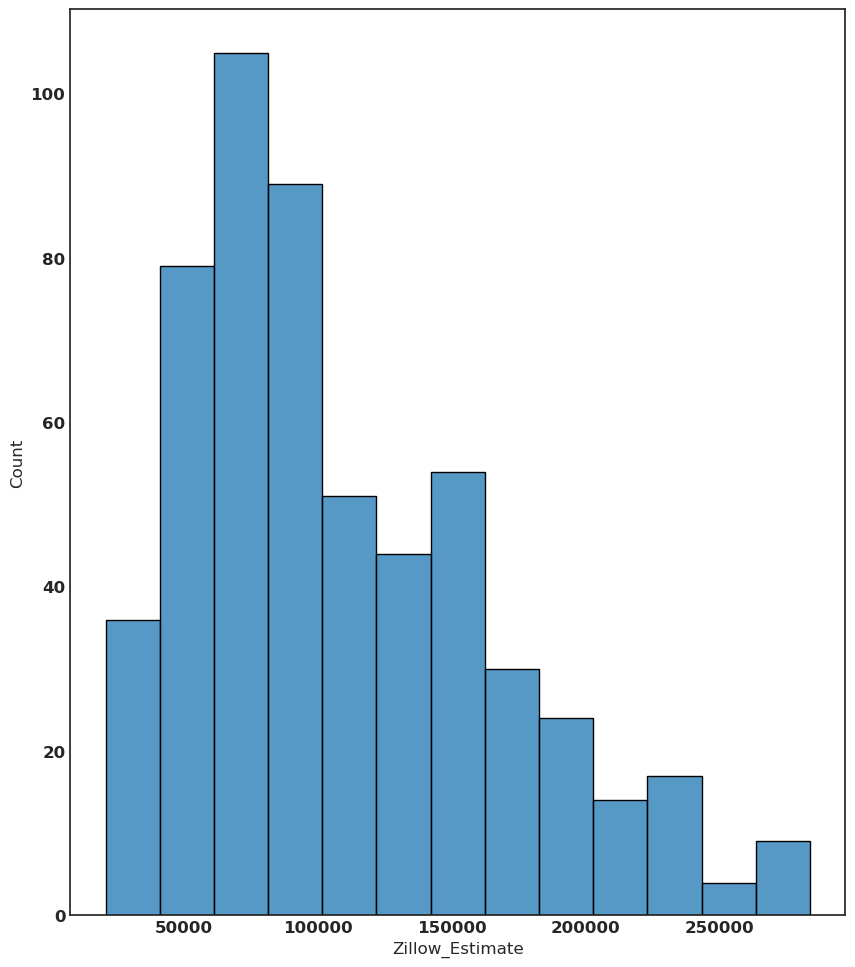

In [47]:
plt.figure(figsize=(10,12),dpi=100)
sns.histplot(x=model_data['Zillow_Estimate'])

In [48]:
dummy_data = pd.get_dummies(model_data,columns=['Crime_Class','Walk_Class','PropType'])

In [49]:
dummy_data

,Zillow_Estimate,SqFt,bathrooms,bedrooms,School_Score,Sheriff_Cost,Crime_Class_Low crime,Crime_Class_Medium crime,Crime_Class_High crime,Crime_Class_Extrem crime,Walk_Class_Car Dependent,Walk_Class_Somewhat Car Dependent,Walk_Class_Somewhat Walkable,Walk_Class_Walkable,Walk_Class_Walkers Paradise,PropType_Condominium,PropType_MultiFamily2To4,PropType_SingleFamily,PropType_Townhouse
0,228663.0,898.0,1.0,2.0,15.87,1314.10,0,0,0,1,0,0,0,0,1,0,0,1,0
1,141579.0,1120.0,1.5,3.0,32.53,1254.05,1,0,0,0,1,0,0,0,0,0,0,0,1
2,186172.0,1882.0,3.0,3.0,7.89,1337.33,0,0,1,0,0,0,1,0,0,0,0,1,0
3,168557.0,1792.0,1.0,4.0,7.89,1459.76,0,0,1,0,0,0,1,0,0,0,0,1,0
4,135045.0,1419.0,2.0,3.0,7.89,1263.36,0,0,1,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,61406.0,2288.0,1.0,5.0,5.63,3060.26,0,0,0,1,0,0,0,1,0,0,0,0,1
611,59447.0,1238.0,1.0,3.0,3.34,2566.47,0,0,0,1,0,0,0,0,1,0,0,0,1
612,20806.0,2315.0,4.0,5.0,28.40,2040.69,0,0,1,0,0,0,0,0,1,0,1,0,0
613,83447.0,3096.0,2.0,6.0,8.34,5736.40,1,0,0,0,1,0,0,0,0,0,0,1,0


In [50]:
dummy_data['Log_Zillow'] = dummy_data['Zillow_Estimate'].apply(math.log)

<AxesSubplot:xlabel='Log_Zillow', ylabel='Count'>

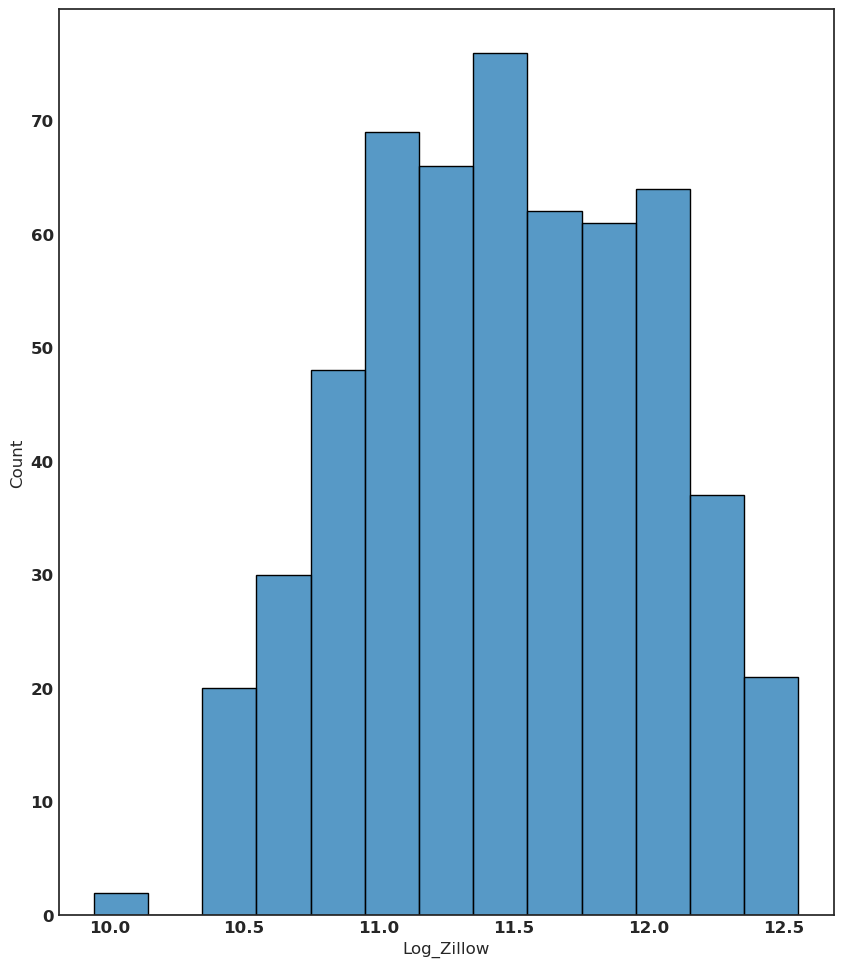

In [51]:
plt.figure(figsize=(10,12),dpi=100)
sns.histplot(x=dummy_data['Log_Zillow'])

In [52]:
X = dummy_data.iloc[:,1:-1].to_numpy()
y = dummy_data.iloc[:,0].to_numpy()
y_log = dummy_data.iloc[:,-1].to_numpy()


In [53]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.80)
y_train_log,y_test_log = train_test_split(y_log,train_size=0.8)

In [54]:
lass = Lasso(alpha=0.01, max_iter=10000).fit(X_train,y_train)
y_test_pred = lass.predict(X_test)
lasso_score = mean_absolute_error(y_test,y_test_pred)

c:\Users\curti\Miniconda3\envs\youtube\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.786e+10, tolerance: 1.390e+08
  model = cd_fast.enet_coordinate_descent(


In [55]:
lasso_score

22542.73295570965

In [56]:
mod = xgboost.XGBRegressor(n_estimators =1000, max_depth=7, eta=0.1, subsample=0.7)

In [57]:
cv = RepeatedKFold(n_splits=10,n_repeats=3,random_state=1)
scores = cross_val_score(mod,X_train,y_train, scoring='neg_mean_absolute_error',cv=cv)

In [58]:
scores = abs(scores)
print('Mean MSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MSE: 23471.846 (3058.229)


In [68]:
lass = Lasso(alpha=0.01, max_iter=10000).fit(X_train,y_train)
scores = cross_val_score(lass,X_train,y_train, scoring='neg_mean_absolute_error',cv=cv)

c:\Users\curti\Miniconda3\envs\youtube\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.786e+10, tolerance: 1.390e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\curti\Miniconda3\envs\youtube\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.321e+10, tolerance: 1.213e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\curti\Miniconda3\envs\youtube\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

In [69]:
scores = abs(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 24721.215 (2669.360)


In [64]:
minmax = MinMaxScaler()
minmax.fit(X_train)
X_train_minmax=minmax.transform(X_train)
X_test_minmax=minmax.transform(X_test)

In [65]:
lass = Lasso(alpha=0.01, max_iter=100000).fit(X_train_minmax,y_train)
scores = cross_val_score(lass,X_train_minmax,y_train, scoring='neg_mean_absolute_error',cv=cv)

c:\Users\curti\Miniconda3\envs\youtube\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.336e+09, tolerance: 1.390e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\curti\Miniconda3\envs\youtube\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.267e+09, tolerance: 1.238e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\curti\Miniconda3\envs\youtube\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

In [67]:
scores = abs(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 24721.222 (2669.372)


In [70]:
mod = xgboost.XGBRegressor(n_estimators =1000, max_depth=7, eta=0.1, subsample=0.7)
cv = RepeatedKFold(n_splits=10,n_repeats=3,random_state=1)
scores = cross_val_score(mod,X_train_minmax,y_train, scoring='neg_mean_absolute_error',cv=cv)

In [71]:
scores = abs(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 23346.746 (2963.911)


In [72]:
svr = SVR()
scores = cross_val_score(svr,X_train_minmax,y_train, scoring='neg_mean_absolute_error',cv=cv)

In [73]:
scores = abs(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 44893.467 (4733.183)


In [78]:
random = RandomForestRegressor()
scores = cross_val_score(random,X_train_minmax,y_train, scoring='neg_mean_absolute_error',cv=cv)

In [79]:
scores = abs(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 21799.003 (2794.872)


In [86]:
params ={'criterion' : ['squared_error','absolute_error','poisson'],'max_depth': [100,200,300,400,500]}

In [87]:
grid = GridSearchCV(random,params,scoring='neg_mean_absolute_error',cv=cv)

In [88]:
grid.fit(X_train_minmax,y_train)

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=1),
             estimator=RandomForestRegressor(),
             param_grid={'criterion': ['squared_error', 'absolute_error',
                                       'poisson'],
                         'max_depth': [100, 200, 300, 400, 500]},
             scoring='neg_mean_absolute_error')

In [89]:
grid.best_score_

-21754.74425387206

In [91]:
grid.best_params_

{'criterion': 'poisson', 'max_depth': 200}

In [92]:
final_model = grid.best_estimator_

In [93]:
final_model.fit(X_train_minmax,y_train)

RandomForestRegressor(criterion='poisson', max_depth=200)

In [97]:
y_pred = final_model.predict(X_test_minmax)
mean_absolute_error(y_test,y_pred)

20991.505

In [98]:
final_model.feature_importances_

array([0.13745749, 0.02615573, 0.01805726, 0.0857767 , 0.63533449,
       0.00349006, 0.00256742, 0.00734419, 0.04031922, 0.00361584,
       0.0029486 , 0.003484  , 0.00755074, 0.00518668, 0.00725119,
       0.00157982, 0.00748777, 0.0043928 ])

In [101]:
dummy_data

,Zillow_Estimate,SqFt,bathrooms,bedrooms,School_Score,Sheriff_Cost,Crime_Class_Low crime,Crime_Class_Medium crime,Crime_Class_High crime,Crime_Class_Extrem crime,Walk_Class_Car Dependent,Walk_Class_Somewhat Car Dependent,Walk_Class_Somewhat Walkable,Walk_Class_Walkable,Walk_Class_Walkers Paradise,PropType_Condominium,PropType_MultiFamily2To4,PropType_SingleFamily,PropType_Townhouse,Log_Zillow
0,228663.0,898.0,1.0,2.0,15.87,1314.10,0,0,0,1,0,0,0,0,1,0,0,1,0,12.340005
1,141579.0,1120.0,1.5,3.0,32.53,1254.05,1,0,0,0,1,0,0,0,0,0,0,0,1,11.860613
2,186172.0,1882.0,3.0,3.0,7.89,1337.33,0,0,1,0,0,0,1,0,0,0,0,1,0,12.134426
3,168557.0,1792.0,1.0,4.0,7.89,1459.76,0,0,1,0,0,0,1,0,0,0,0,1,0,12.035029
4,135045.0,1419.0,2.0,3.0,7.89,1263.36,0,0,1,0,0,0,1,0,0,0,0,1,0,11.813363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,61406.0,2288.0,1.0,5.0,5.63,3060.26,0,0,0,1,0,0,0,1,0,0,0,0,1,11.025263
611,59447.0,1238.0,1.0,3.0,3.34,2566.47,0,0,0,1,0,0,0,0,1,0,0,0,1,10.992840
612,20806.0,2315.0,4.0,5.0,28.40,2040.69,0,0,1,0,0,0,0,0,1,0,1,0,0,9.942997
613,83447.0,3096.0,2.0,6.0,8.34,5736.40,1,0,0,0,1,0,0,0,0,0,0,1,0,11.331967


In [104]:
pd.DataFrame({'Variable':dummy_data.columns[1:-1],
              'Importance':final_model.feature_importances_}).sort_values('Importance', ascending=False)

,Variable,Importance
4,Sheriff_Cost,0.635334
0,SqFt,0.137457
3,School_Score,0.085777
8,Crime_Class_Extrem crime,0.040319
1,bathrooms,0.026156
2,bedrooms,0.018057
12,Walk_Class_Walkable,0.007551
16,PropType_SingleFamily,0.007488
7,Crime_Class_High crime,0.007344
14,PropType_Condominium,0.007251
